# Digit Recognizer — A Practical CNN Approach with Error Analysis

This notebook presents a complete solution to Kaggle’s **Digit Recognizer** competition
using a **Convolutional Neural Network (CNN)**.

Rather than focusing only on model architecture, the emphasis here is on building a
robust pipeline:
- clean preprocessing
- realistic data augmentation
- stable training
- and systematic error analysis

This approach mirrors how image classification models are improved in practice:
by studying failure cases and making targeted refinements.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dense,
    Dropout, Flatten, BatchNormalization
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Input

2026-02-08 06:45:33.551946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770533133.784543      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770533133.860661      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770533134.406752      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770533134.406810      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770533134.406813      17 computation_placer.cc:177] computation placer alr

## 2. Loading the Dataset

The Digit Recognizer dataset is provided as two CSV files:

- `train.csv`:  
  - Each row represents one image  
  - First column is the **label** (0–9)  
  - Remaining 784 columns are pixel values (28×28 image)

- `test.csv`:  
  - Same pixel format  
  - No labels (this is what we predict for Kaggle submission)

In [3]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


## 3. Separating Images and Labels

We separate:
- `X` → pixel values (input features)
- `y` → digit labels (targets)

This makes the data easier to process and model.

In [4]:
X = train.drop("label", axis=1)
y = train["label"]

## 4. Normalizing the Data

Pixel values range from **0 to 255**.

We divide by 255 to scale them into the range **0 to 1**.

Why this matters:
- Neural networks train faster
- Gradients are more stable
- This is standard practice for image models


In [5]:
X = X / 255.0
test = test / 255.0

## 5. Reshaping Images for CNNs

CNNs expect image-shaped input:

(height, width, channels)

So we reshape:
- From: (784,)
- To: (28, 28, 1)

The last dimension (`1`) indicates a grayscale image.

In [6]:
X = X.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

## 6. One-Hot Encoding Labels

Digits like `5` are converted into vectors like:

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

Why?
- The model outputs probabilities for each digit (0–9)
- This format works with the `softmax` output layer

In [7]:
y = to_categorical(y, num_classes=10)

## 7. Visualising Training Images

Before training, it’s important to **look at the data**.

Here we display a few handwritten digits to:
- Confirm the data loaded correctly
- Understand how messy handwriting can be

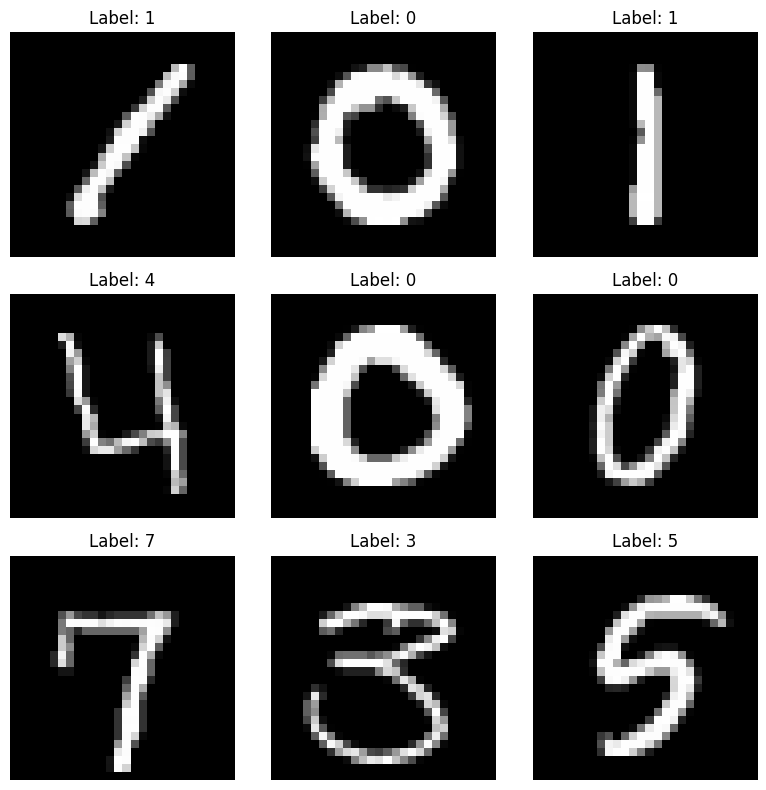

In [8]:
plt.figure(figsize=(8, 8))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap="gray")
    plt.title(f"Label: {np.argmax(y[i])}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 8. Data Augmentation

Handwritten digits vary a lot:
- Slight rotations
- Shifts
- Different sizes and angles

Data augmentation artificially creates these variations.

This helps the model:
- Generalize better
- Avoid memorizing exact training images

In [9]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

datagen.fit(X)

## 9. Visualising Augmented Images

Here we visualise augmented samples to see what the model actually trains on.

This confirms that:
- Augmentations are realistic
- Images are still readable digits

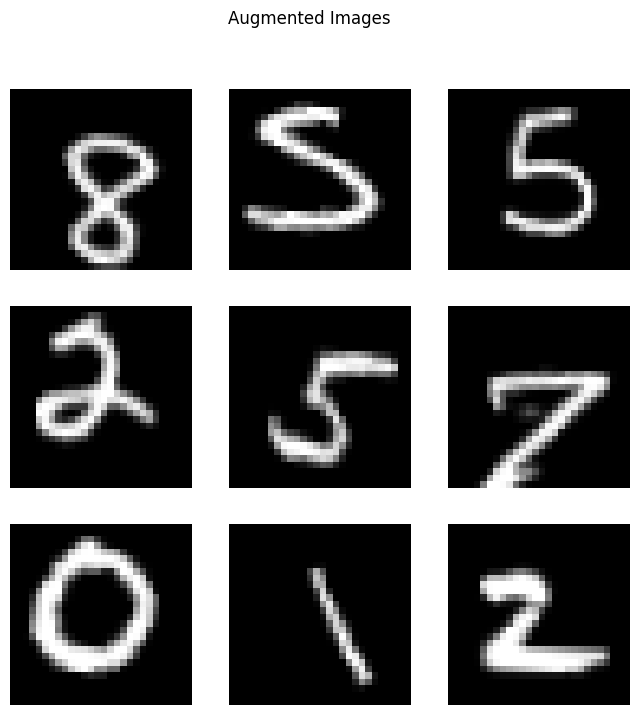

In [10]:
plt.figure(figsize=(8,8))

for X_batch, y_batch in datagen.flow(X, y, batch_size=9):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(X_batch[i].reshape(28,28), cmap="gray")
        plt.axis("off")
    break

plt.suptitle("Augmented Images")
plt.show()

## 10. Building the Convolutional Neural Network (CNN)

CNNs are designed specifically for images.

High-level structure:
1. **Convolution layers** → detect edges, curves, strokes
2. **Pooling layers** → reduce image size and noise
3. **Dense layers** → make final classification

In [11]:
model = Sequential([
    Input(shape=(28,28,1)),

    Conv2D(32, 3, activation="relu"),
    BatchNormalization(),
    Conv2D(32, 3, activation="relu"),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(128, 3, activation="relu"),
    BatchNormalization(),
    Conv2D(128, 3, activation="relu"),
    MaxPooling2D(),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),

    Dense(10, activation="softmax")
])

2026-02-08 06:45:56.382082: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 11. Model Compilation

We use:
- **Adam optimizer** → fast and reliable
- **Categorical Crossentropy** → standard for multi-class classification
- **Label smoothing** → reduces overconfidence

Label smoothing helps when the model is *confident but wrong*.

In [12]:
loss = CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"]
)

## 12. Training Strategy

We use two callbacks:

1. **ReduceLROnPlateau**
   - Lowers learning rate when validation loss stops improving

2. **EarlyStopping**
   - Stops training when no improvement is observed
   - Restores the best-performing model

In [13]:
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

## 13. Training the Model

We train using:
- Augmented training data
- Clean validation data (no augmentation)

This setup gives a realistic estimate of real-world performance.

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42
)

In [15]:
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1
)

datagen.fit(X_train)

In [16]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=20,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train)//64,
    callbacks=[lr_scheduler, early_stop]
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


590/590 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - accuracy: 0.6264 - loss: 1.5667 - val_accuracy: 0.9743 - val_loss: 0.6666 - learning_rate: 0.0010
Epoch 2/20
  1/590 ━━━━━━━━━━━━━━━━━━━━ 1:08 116ms/step - accuracy: 0.9688 - loss: 0.6860

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9688 - loss: 0.6860 - val_accuracy: 0.9752 - val_loss: 0.6638 - learning_rate: 0.0010
Epoch 3/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 72s 123ms/step - accuracy: 0.9340 - loss: 0.7534 - val_accuracy: 0.9817 - val_loss: 0.6174 - learning_rate: 0.0010
Epoch 4/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8906 - loss: 0.8199 - val_accuracy: 0.9817 - val_loss: 0.6179 - learning_rate: 0.0010
Epoch 5/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 71s 120ms/step - accuracy: 0.9595 - loss: 0.6822 - val_accuracy: 0.9850 - val_loss: 0.6005 - learning_rate: 0.0010
Epoch 6/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9531 - loss: 0.6655 - val_accuracy: 0.9852 - val_loss: 0.6009 - learning_rate: 0.0010
Epoch 7/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 70s 119ms/step - accuracy: 0.9703 - loss: 0.6456 - val_accuracy: 0.9910 - val_loss: 0.5684 - learning_rate: 0.0010
Epoch 8/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9531 - loss: 0.6402 - va

## 14. Training Curves

We plot:
- Training accuracy vs validation accuracy
- Training loss vs validation loss

Healthy training:
- Accuracy increases
- Loss decreases
- Training and validation curves stay close

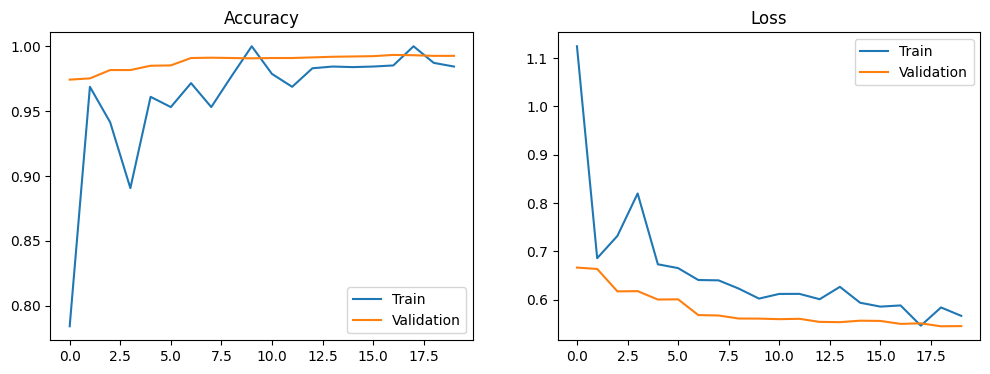

In [17]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.show()

## 15. Error Analysis

Instead of blindly improving the model, we analyse:
- Which images are misclassified
- How confident the model was when it was wrong
- Which digits confuse the model the most

In [18]:
y_val_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [19]:
errors = np.where(y_val_pred != y_val_true)[0]
print("Validation errors:", len(errors))

Validation errors: 31


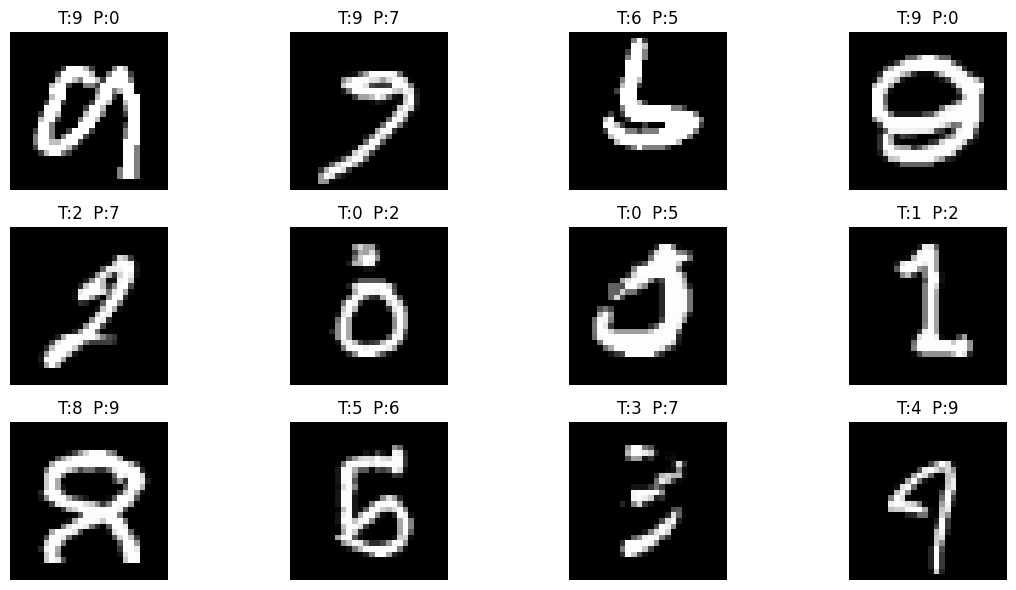

In [20]:
plt.figure(figsize=(12,6))

for i, idx in enumerate(errors[:12]):
    plt.subplot(3,4,i+1)
    plt.imshow(X_val[idx].reshape(28,28), cmap="gray")
    plt.title(f"T:{y_val_true[idx]}  P:{y_val_pred[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

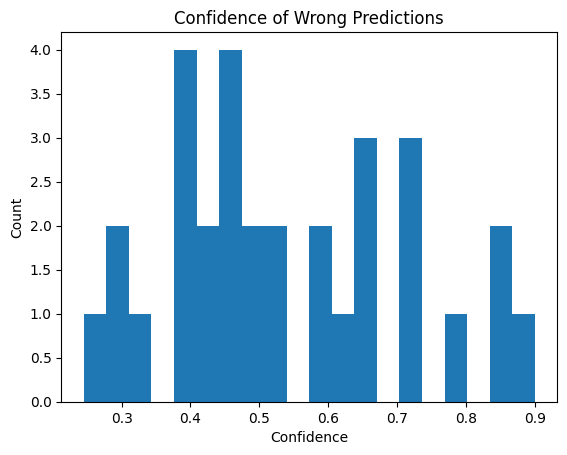

In [21]:
error_confidence = y_val_probs[errors].max(axis=1)

plt.hist(error_confidence, bins=20)
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.title("Confidence of Wrong Predictions")
plt.show()

## 16. Confusion Matrix

The confusion matrix shows:
- True digit vs predicted digit
- Which digits are commonly confused (e.g. 4 vs 9)

This helps us understand systematic errors.

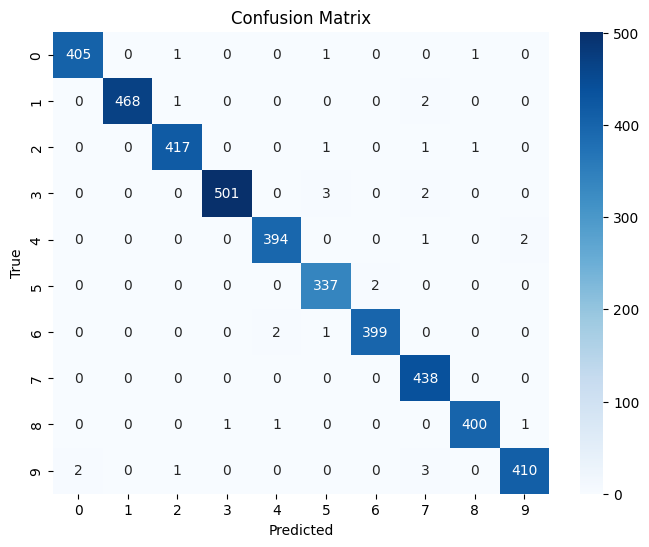

In [22]:
cm = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## 17. High-Confidence Mistakes

These are the most dangerous errors:
- The model is **very confident**
- But still wrong

Fixing these gives the biggest accuracy gains.

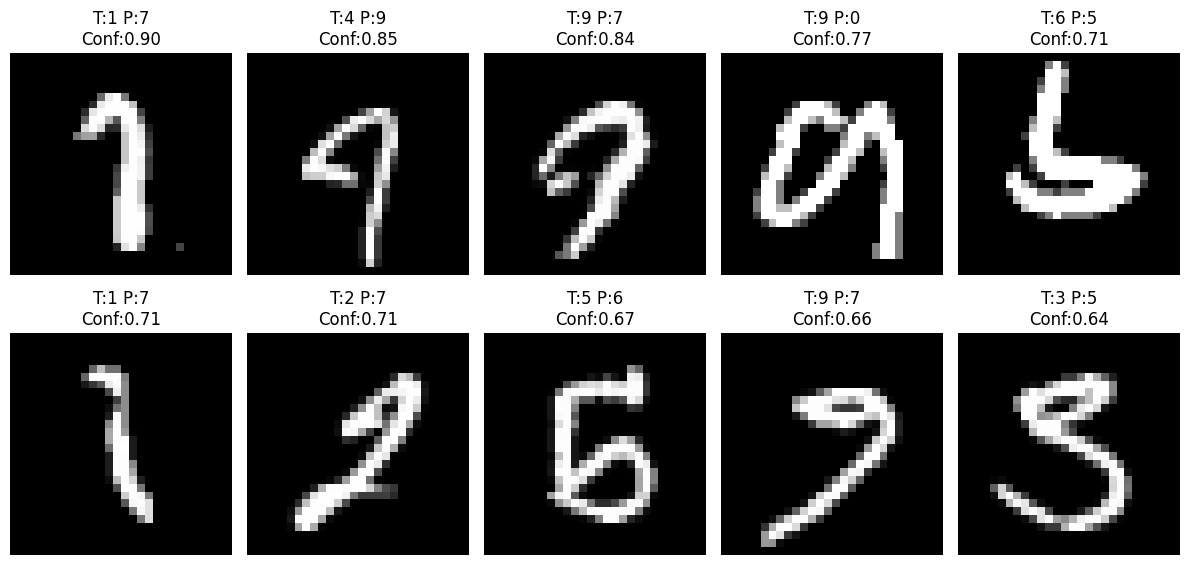

In [23]:
high_conf_errors = errors[np.argsort(-error_confidence)]

plt.figure(figsize=(12,6))
for i, idx in enumerate(high_conf_errors[:10]):
    plt.subplot(2,5,i+1)
    plt.imshow(X_val[idx].reshape(28,28), cmap="gray")
    plt.title(
        f"T:{y_val_true[idx]} P:{y_val_pred[idx]}\n"
        f"Conf:{y_val_probs[idx].max():.2f}"
    )
    plt.axis("off")

plt.tight_layout()
plt.show()

In [24]:
predictions = model.predict(test)
predicted_labels = np.argmax(predictions, axis=1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step


## 18. Creating the Kaggle Submission

Finally:
- Predict digits for the test set
- Format predictions correctly
- Save as `submission.csv`

This file can be uploaded directly to Kaggle.

In [25]:
submission = pd.DataFrame({
    "ImageId": np.arange(1, len(predicted_labels)+1),
    "Label": predicted_labels
})

submission.to_csv("submission.csv", index=False)
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


# Conclusion — What Really Improves Accuracy

This notebook demonstrates that achieving high accuracy on MNIST is not about using
the biggest or most complex model.

Instead, the biggest improvements come from:
- Understanding the data
- Using realistic data augmentation
- Monitoring validation performance
- Carefully analysing model errors
- Making **targeted improvements** based on those errors

By visualising misclassified digits and studying high-confidence mistakes, we move from
“training models” to **understanding models**.

---

### Key Takeaways
- CNNs excel at image recognition because they learn spatial patterns
- Data augmentation helps models generalise to real-world variations
- Validation data should remain clean and untouched
- Error analysis is one of the most powerful and overlooked tools in machine learning
- Small, thoughtful improvements can outperform brute force approaches

---
